In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mag_calc import MagCalc
from tqdm import tqdm
from scipy import linalg as la
import pandas as pd

%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 150
plt.style.use('ggplot')

In [6]:
spins1 = np.load('spin_atom_arrays/1_1_1_spins.npy')
atoms1 = np.load('spin_atom_arrays/1_1_1_atoms.npy')

spins2 = np.load('spin_atom_arrays/1_-1_0_spins.npy')
atoms2 = np.load('spin_atom_arrays/1_-1_0_atoms.npy')

In [7]:
up = (np.linalg.norm(spins1-spins1[0],axis=1)<0.00001)

In [10]:
spins1 

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027,  0.57735027],
       ...,
       [ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [-0.57735027, -0.57735027, -0.57735027]])

In [13]:
generic = spins1 * np.sqrt(3)

In [14]:
generic

array([[ 1.,  1.,  1.],
       [-1., -1., -1.],
       [ 1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

In [4]:
split = 11490 // 5
num_spins = len(spins1)

indicies = np.random.permutation(num_spins)

temp_spins1 = spins1.copy()
temp_spins1[indicies[:split]] *= .5
temp_spins1[indicies[split:split * 2]] *= 1.5
temp_spins1[indicies[-split * 2:]] *= 0

temp_spins2 = spins2.copy()
temp_spins2[indicies[:split]] *= .5
temp_spins2[indicies[split:split * 2]] *= 1.5
temp_spins2[indicies[-split * 2:]] *= 0

In [5]:
calc1 = MagCalc(atoms=atoms1, 
               spins=temp_spins1, 
               g_factor=2, 
               spin=1, 
               magneton='mu_B')
calc2 = MagCalc(atoms=atoms2,
               spins=temp_spins2,
               g_factor=2,
               spin=1,
               magneton='mu_B')
calc_list = [calc1, calc2]

In [6]:
%%time

resolution = 40
side_length = 20

calc1.spins = calc1.spins[np.random.permutation(num_spins)]
plane = calc1.make_plane(center_point=np.array([0,0,1.1]),
                         mask_radius=8,
                         resolution=resolution,
                         side_length=side_length)

CPU times: user 7min 35s, sys: 397 ms, total: 7min 35s
Wall time: 7min 36s


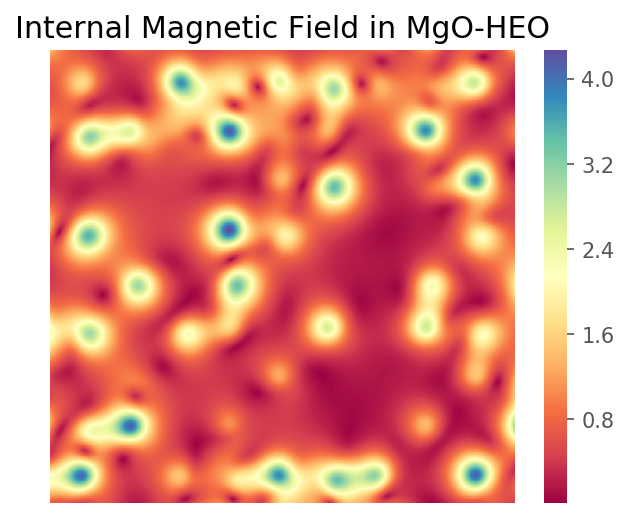

In [8]:
sns.heatmap(plane, cmap='Spectral')
plt.gcf().set_size_inches(5,4)
plt.title('Internal Magnetic Field in MgO-HEO')
plt.axis('off')
# plt.savefig('mgo_heo_pres/mgo_heo_field', dpi=250)
plt.show()

In [6]:
magnitudes = [.75, 1, 1.25, 1.5]

loc1 = np.array([1, 1, 1])
loc2 = np.array([1, 1, -1])
loc3 = np.array([1, -1, 1])
loc4 = np.array([1, -1, -1])
loc5 = np.array([-1, 1, 1])
loc6 = np.array([-1, 1, -1])
loc7 = np.array([-1, -1, 1])
loc8 = np.array([-1, -1, -1])

locs = [loc1, loc2, loc3, loc4, loc5, loc6, loc7, loc8]

In [7]:
def plot_fields(field_df, 
                bins, 
                magnitude, 
                basis,
                location, 
                save=True,
                plot=True):
    
    for i, col in enumerate(field_df.columns):
        plt.subplot(2,2,i+1)
        plt.hist(field_df[col], bins=bins, density=True)
        plt.title(col)
        
        if col == 'Magnitude':
            plt.xlim(0, 2)
            plt.ylim(0, 1.75)
        else:
            plt.xlim(-1.5, 1.5)
            plt.ylim(0, 1.25)
    
    plt.suptitle('Magnitude: {}, Basis: {}, Location: {}'.format(magnitude, basis, tuple(location.tolist())))
    plt.tight_layout(rect = [0, .03, 1, .95])
    plt.gcf().set_size_inches(10,6)
    
    if save is True:
        plt.savefig('distributions/dist/mag_{}_basis_{}_loc_{}'.format(int(magnitude*100), basis, tuple(location.tolist())), dpi=150)
        
    if plot is True:
        plt.show()
    else:
        plt.clf()

In [8]:
%%time

n = int(5e4) 
bins = 50
bases = ['(1,1,1)', '(1,-1,0)']
save = True
plot = False


for basis, calc in zip(bases, calc_list):
    for i, magnitude in enumerate(magnitudes):
        mag = magnitude / np.sqrt(3)
    
        for j, location in enumerate(locs):
            loc = location * mag
            mask = calc.make_mask(loc.reshape(1,-1), 12)
            fields = []
            field_comps = []
        
            for k in tqdm(range(n)):
#                 th = np.arccos(np.random.uniform(-1,1))
#                 phi = np.random.uniform(-np.pi,np.pi)
#                 randomBasisVec = np.array([np.cos(phi)*np.sin(th),np.sin(phi)*np.sin(th),np.cos(th)])
#                 calc.spins[up] = randomBasisVec
#                 calc.spins[~up] = -randomBasisVec
                calc.spins = calc.spins[np.random.permutation(num_spins)] * -1
                field = calc.calculate_field(loc, return_vector=True, mask=mask)
                fields.append((la.norm(field), *field))
                
            field_df = pd.DataFrame(columns=['Magnitude', 'X', 'Y', 'Z'], data=fields)
            
            if save is True:
                field_df.to_csv('distributions/data/mag_{}_basis_{}_loc_{}'.format(int(magnitude*100), basis, tuple(location.tolist())))
            
            plot_fields(field_df, 
                        bins,
                        magnitude,
                        basis,
                        location,
                        save,
                        plot)

100%|██████████| 50000/50000 [00:32<00:00, 1543.63it/s]


CPU times: user 34min 41s, sys: 11.9 s, total: 34min 53s
Wall time: 1h 34min 54s


<Figure size 1500x900 with 0 Axes>

In [11]:
phi = np.random.uniform(-np.pi, np.pi, calc.spins.shape[0])
theta = np.arccos(np.random.uniform(-1, 1, calc.spins.shape[0]))

random_spins = np.array([np.sin(theta)* np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T

In [12]:
%%time

fields = []
n = int(1e5)
location = np.ones(3) * 1.5
rand_calc = MagCalc(atoms=atoms1, spins=random_spins, g_factor=2, spin=1, magneton='mu_B')
mask = rand_calc.make_mask(location.reshape(1,-1), 12)

for i in tqdm(range(n)):
    rand_calc.spins = rand_calc.spins[np.random.permutation(11489)]
    
    field = rand_calc.calculate_field(location, return_vector=False, mask=mask)
    fields.append(field)

100%|██████████| 100000/100000 [01:19<00:00, 1255.33it/s]

CPU times: user 1min 19s, sys: 272 ms, total: 1min 20s
Wall time: 1min 19s


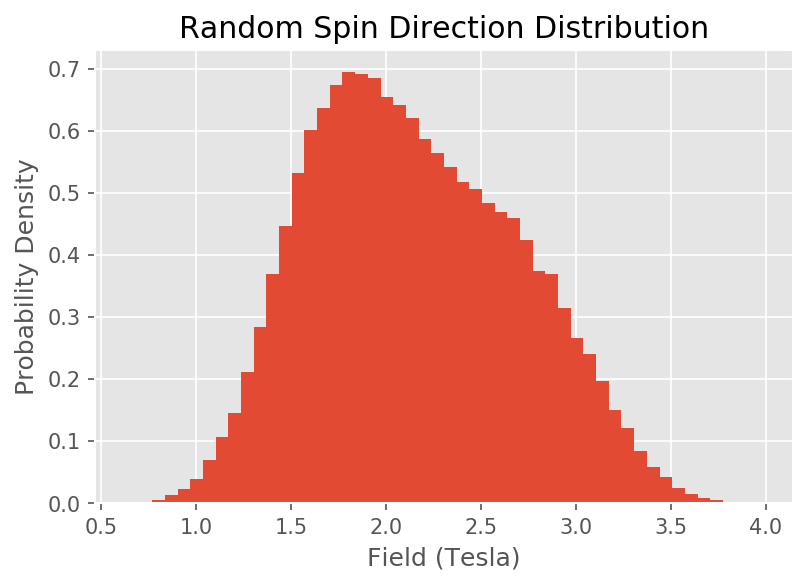

In [13]:
plt.hist(fields, bins=50, density=True)
plt.title('Random Spin Direction Distribution')
plt.xlabel('Field (Tesla)')
plt.ylabel('Probability Density')
plt.savefig('mgo_heo_pres/random_distribution', dpi=200)
plt.show()

In [14]:
%%time

fields = []
n = int(1e6)
location = np.ones(3) * 1.5
mask = calc1.make_mask(location.reshape(1,-1), 12)

for i in tqdm(range(n)):
    calc1.spins = calc1.spins[np.random.permutation(11489)]
    
    field = calc1.calculate_field(location, return_vector=False, mask=mask)
    fields.append(field)

100%|██████████| 1000000/1000000 [12:23<00:00, 1344.60it/s]

CPU times: user 12min 25s, sys: 2.05 s, total: 12min 27s
Wall time: 12min 23s


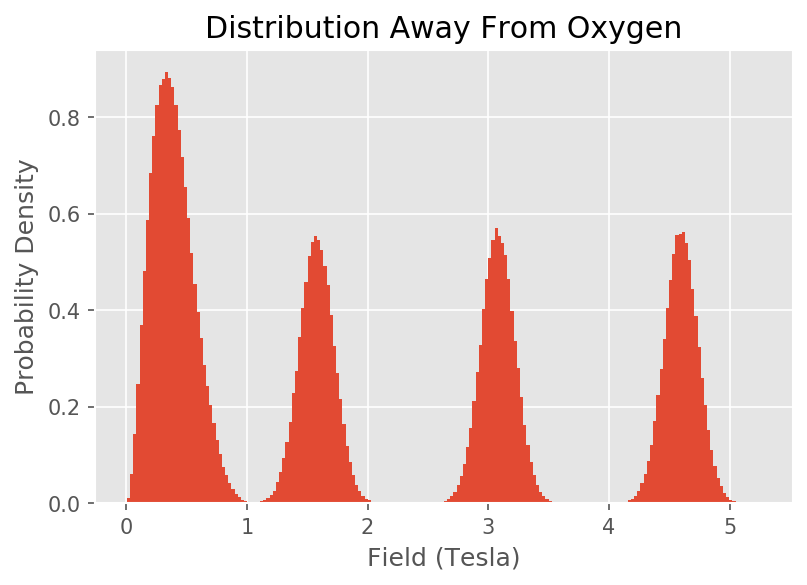

In [15]:
plt.hist(fields, bins=200, density=True)
plt.title('Distribution Away From Oxygen')
plt.xlabel('Field (Tesla)')
plt.ylabel('Probability Density')
plt.savefig('mgo_heo_pres/distribution_with_peaks', dpi=200)
plt.show()